# Bayesian Regression, Calibration, and Prediction

In this notebook we are going to see an application Bayesian linear regression, applied to the kind of data paleoclimatologists might encounter -- a set of proxy measurements (the response) that reflect sea surface temperatures (the predictor).  We don't expect to get a demonstrably different answer to our regression calibration problem in this case.  But this example does show a more real-world application of a Bayesian framework in a familiar context, and introduces how Bayesian calibration can be applied to the inverse problem in a way that is etiologically correct (relating cause to response, not the otherway around).

Let's get our libraries.  From Scipy's statistics sublibrary, we'll need modules for the inverse gamma distribution, the multivariate and univariate normal distribution, and a Kernel Density Estimator (KDE).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
from scipy.stats import invgamma, multivariate_normal, norm, gaussian_kde
# plt.rcParams['font.family'] = 'Helvetica'

### Step 1: Define our predictor (X) and response (Y) data

We're going to create from simulated data where the cause and effect are correctly aligned -- sea surface temperatures (SST) cause variability in the alkenones (organic molecules) produced by some phytoplankton species.  Here, we define our `X` as the explanatory variables and `Y` as the observations. Here then `X` represents SST, and `Y` represents the UK37 index used to measure alkenone sensitivity to past ocean temperatures (the index range from 0 to 1, which is saturated).

First we'll generate simulated random SST values from 0 to 28C, a nice modern Earth's ocean temperature range:

In [20]:
X = 28 * np.random.rand(100, 1)

Now we generate the simulated UK37 index values from the SSTs we created above using [Prahl's equation](https://www.sciencedirect.com/science/article/pii/0016703788901329) and we will also add some Gaussian random noise with a standard deviation of 0.05 (We could think of this as reflecting some combination of measurement error and other uncertainties)"

In [23]:
Y = (X * 0.034 + 0.039) + 0.05 * np.random.randn(100, 1)

Let's plot our simulated data to make sure it approximates the alkenone system we're trying to reproduce:

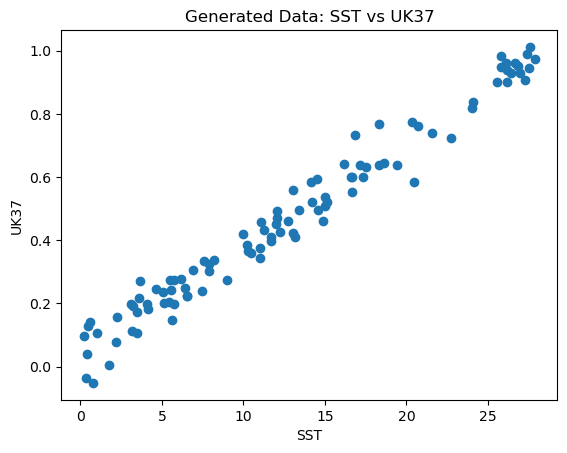

In [26]:
plt.figure()
plt.scatter(X, Y)
plt.xlabel('SST')
plt.ylabel('UK37')
plt.title('Generated Data: SST vs UK37')
plt.show()


Looks good.  

Next, we'll get the simple Ordinary Least Square (OLS) frequentist regression coefficients.

### Step 2: the Ordinary Least Squares solution

Here we'll calculate the least squares solution for the regression coefficients B (Bhat, including intercept and slope) and the variance (tau^2hat) of the residual of that linear fit.  We can use a linear algebra approach for the least squares approximation of coefficients $\hat{B}$ (we'll call this 'Bhat' in our code) - this should be the Best Linear Unbiased Estimate:

$
\hat{B} = (X^T X)^{-1} X^T Y
$

In [30]:
# We'll first add a column of ones to our `X` (predictor) so that we can also calculate the intercept term from the linear algebra
X = np.hstack([X, np.ones((100, 1))])

# Linear algebra approach to estimating slope and intercept coeffients 
Bhat = linalg.inv(X.T @ X) @ (X.T @ Y)

In [32]:
Bhat

array([[0.03356312],
       [0.04183335]])

For the variance of the residual (the misfit between our OLS line and the actual values) from the regression, which we designate the variable $\hat{\tau}^2$.  The equation below calculates the residuals from the OLS fit (which has the  or coefficients of the regression in $\hat{B}$)) and then determines their variance, which is a single number.  The first term in the calculation below accounts for the degrees of freedom (reducing the number of observations by two for each coefficient estimated):


In [40]:
tau2hat = (1 / (X.shape[0] -  X.shape[1])) * ((Y - X @ Bhat).T @ (Y - X @ Bhat)).item() # appending .item turns the result of our matrix multiplication into a scalar 

Let's see what our OLS solution provides for parameters:

In [43]:
print("Coefficients (Slope, Intercept):", Bhat.flatten())
print("OLS residual variance", tau2hat)

Coefficients (Slope, Intercept): [0.03356312 0.04183335]
OLS residual variance 0.0024364865643758736


Simple enough!  We have a slope of ~0.032 and an intercept of ~0.05.  The variance of the residuals is quite small at 0.002. 

We'll now do take the Bayesian approach, using what we've learned from OLS as a basis for our priors.

### Step 3: Set up Bayesian priors

Here, we first define the priors for the Bayesian regression coefficients (the $\beta$) using a multivariate normal prior, since we need to eventually find the posterior distribution of the two regression coefficients:  

In [49]:
# Mean of the prior is just the single OLS estimates for the coefficients
mean_prior = Bhat.flatten() # just the array of the coefficients from OLS

# For the prior variance, we can assume a relatively large uncertainty around the dimensions of Bhat - this will be a very flat or 'uninformative' prior
var_prior = (2 * Bhat.flatten()) ** 2 # twice the size of the coefficients squared gives us the prior variance 
cov_prior = np.diag(var_prior)  # Make a variance-covariance matrix from the variance for the bivariate prior

In [54]:
cov_prior #pretty uncorrelated prior

array([[0.00450593, 0.        ],
       [0.        , 0.00700012]])

Let us take a moment and visual what this prior looks like.  We'll create the bivariate prior using the prior mean and (co)variance.  You'll notice that since the covariance matrix had zero on the off-diagonals (the covariance) and the variance on the diagonals, there is not a relationships in the prior between slope and intercept prior distributions.  Again, this is rather intentionally broad and uninformative:

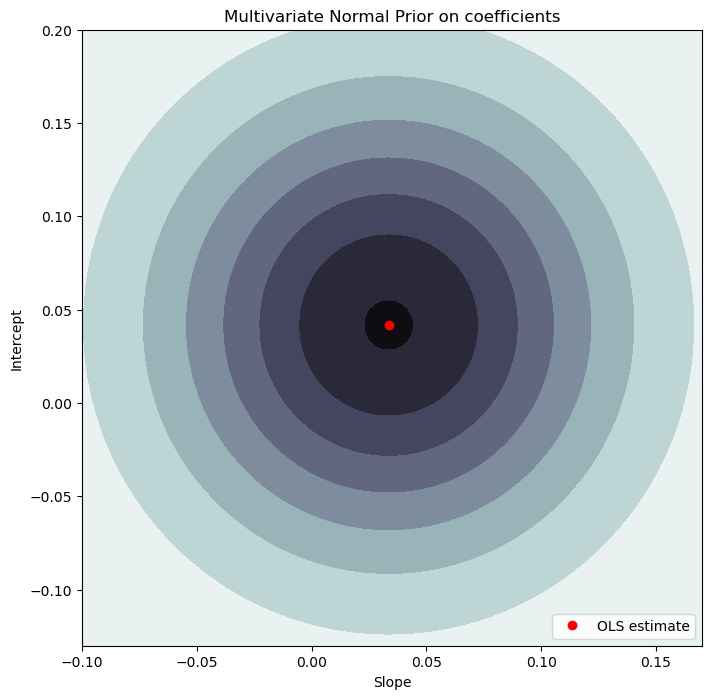

In [52]:
x1 = np.linspace(-0.1, 0.17, 100)
x2 = np.linspace(-0.13, 0.2, 100)
X1, X2 = np.meshgrid(x1, x2) # create coordinates for each 2D location
pos = np.dstack((X1, X2)) # stack these to pass to the multivariate prior pdf 
F = multivariate_normal(mean_prior, cov_prior).pdf(pos) # creates the bivariate prior PDF at all grid points with a given mean and covariance

plt.figure(figsize=(8, 8))
plt.contourf(x1, x2, F, cmap='bone_r')
plt.plot(Bhat[0], Bhat[1], 'ro', label='OLS estimate')
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Multivariate Normal Prior on coefficients')
plt.legend(loc='lower right')

plt.show()

We now need a prior for our other parameter, the residual variance, $\hat{\tau}^2$.  We will construct this one as a inverse gamma distribution.  In Bayesian linear regression, this prior on this parameter is necessary because it is an unknown that we need to estimate based on evidence -- in otherwords, we don't know the residual variance from our regression so we need to calculate it.  This parameter serves a few purposes:  first, it reflects the uncertainty in our model ft to the data and can tell us how precise (or uncertain) our coefficient estimates might be.  Second, it can help prevent overfitting in the regression (e.g. it allows for error and uncertainty in the fit).  We choose the inverse gamma distribution for this residual variance prior because it is a _conjugate prior_ for the variance of a normal distribution.  This makes the calculations and the Bayesian updating computationally much easier. 

Smaller values for the $\alpha$ and $\beta$ parameters for the [inverse gamma](https://distribution-explorer.github.io/continuous/inverse_gamma.html) will give a broader, flatter prior.  [A rule of thumb](https://rss.onlinelibrary.wiley.com/doi/10.1111/j.2517-6161.1973.tb00937.x) for the residual variance inverse gamma prior is to use an $\alpha$ of 2 or 3 and then set the $\beta$ to twice or more of the residual from the simple OLS estimate (which we calculated above).  We'll so this here:

In [57]:
a = 2 # try some different values here to see how it affects the prior distribution
b = 0.005 # a bit more than twice the residual variance from OLS - can be broad to allow a wider prior

We can then visualize of prior for the residual variance by passing the parameters for the inverse Gamma distribution to `invgamma.pdf` and plotting:

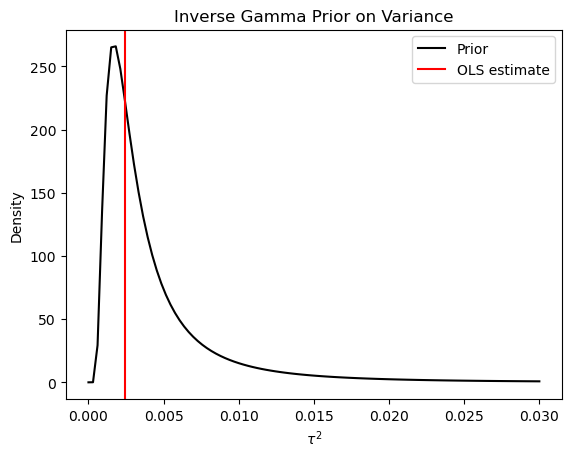

In [60]:
x3 = np.linspace(0, 0.03, 100)
y1 = invgamma.pdf(x3, a, scale=b)

plt.figure()
plt.plot(x3, y1, 'k', label='Prior')
plt.axvline(tau2hat,0,1, color='r', label='OLS estimate')
plt.title('Inverse Gamma Prior on Variance')
plt.xlabel(r'$\tau^2$') # residual variance 
plt.ylabel('Density')
plt.legend()
plt.show()

### Step 4: Gibbs Sampler

One complication that we have not yet encountered in practice is that often our prior and likelihood distributions are not _conjugate_ - that is, multiplying them does not give you a known distribution.  In this case, you use a numerical simulation approach to find the posterior, known as [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).  There are different algorithms for MCMC, but one of the simplest is a [Gibbs Sampler](https://en.wikipedia.org/wiki/Gibbs_sampling). The Gibbs Sampler works as long as the conditional posteriors are of a known form (even if the full posterior is not).

We're going to use a Gibbs sampler here to calculate the posterior for our two linear regression coefficients and for the residual variance.  The producer goes like this:

1. Decide on the number of _chains_ you will use (here we pre-allocate the output arrays for the regression coefficients and the residual variance with empty Numpy arrays, which is good practice). In MCMC, 'chains' refer to separate and independent sequences of samples generated by the sampler (here, the Gibbs sampler, but there are others). Using multiple chains for sampling addresses a few potential issues:  First, it can reveal any sensitivity to the initial values of a chain. Second, we can observe if all the chains eventually converge on the same distrbution. Finally, it eventually helps us deal with the value-to-value autocorrelation in individual chains. 
2. Decide on the number of _draws_ you will use.  When considering how many draws or iterations to get from an MCMC sampler, consider the following:  first, you will probably throw away some of the initial part of each chain, to account for the 'burn in' while the sampler gets close to the region of the multivariate target distribution.  Second, most MCMC samplers will be autocorrelated by nature, so you'll want enough samples to account for the loss of degrees of freedom.  Finally, you'll want enough draws that your sampler chains converges on a posterior distribution.  We'll generally use more than 1000 -- and sometimes quite a few more.  
3. We'll initialize the procedure by first selecting random initial starting points. 
4. We then iterate through each chain. At each step, we sample from the conditional distribution of our variables (that is, the value of one variable conditioned on the value of the other variable, given the variables mean, variance, and covariance).  Each iteration of the sample updates our variables. 
5. Assuming we reach convergence, the samples we now have should approximate the joint distribution of the variables. 

In [62]:
# initialize the Gibbs sampler
n_chains = 5  # Number of chains
n_draws = 2000  # Number of draws
b_draws = np.empty((n_chains, n_draws, X.shape[1])) # preallocate beta draws 
tau2_draws = np.empty((n_chains, n_draws)) # preallocate residual variance draws

The loop below is the Gibbs sampler itself (this is based on an original MATLAB script from Jess Tierney and Martin Tingley).  The outer loop initiates each chain and sets the initial value of the residual variable to a scaled random value.  For each chain, the sampler then loops through the number of draws. 

In [65]:
for i in range(n_chains):
    tau2_val = 0.02 * np.random.rand()
    for kk in range(n_draws):
        
        # Conditional posterior of b
        b_covar = linalg.inv((X.T @ X) / tau2_val + linalg.inv(cov_prior)) # covarance of the beta coefficients conditioned on the residual variance
        b_mn = b_covar @ (linalg.inv(cov_prior) @ mean_prior + X.T @ Y.flatten() / tau2_val) # mean values of the coefficients conditioned on the residual variance
        b_val = multivariate_normal(b_mn, b_covar).rvs() # draw randomly (the .rvs) from a multivariate normal with the given mean and covariance values

        # Marginal posterior for tau^2
        p_a = a + X.shape[0] / 2 # 1st parameter for the inverse gamma - depends on the prior 
        p_b = b + 0.5 * ((Y - X @ b_val.reshape(-1, 1)).T @ (Y - X @ b_val.reshape(-1, 1))).item() # second parameter for the inverse gamma conditioned on the model fit
        tau2_val = 1 / np.random.gamma(p_a, 1 / p_b) # random draw from the inverse gamma with those parameters
        
        # save the sampled parameters
        b_draws[i, kk, :] = b_val # for each chain i and each draw k, save the beta coefficients
        tau2_draws[i, kk] = tau2_val # for each chain i and each draw k, save the residual variance

### Step 5: Check the Results<br>
Once the sampler is done, we can calculate the mean values for `b_draws` and `tau2_draws` to verify they make general sense given the data and our prior expectations:

In [68]:
print("Mean Slope:", np.mean(b_draws[:, :, 0])) # compare to 0.03503402
print("Mean Intercept:", np.mean(b_draws[:, :, 1])) # compare to 0.02451226
print("Mean tau^2:", np.mean(tau2_draws)) # compare to 0.0019538023979394662

Mean Slope: 0.03356711059467411
Mean Intercept: 0.04177496381322346
Mean tau^2: 0.002484877364172233


Looks like what we would have expected!  We can move to look at other diagnostics and the posterior parameter distributions.

### Step 6: Plot and check the MCMC chains

Here we plot and visually check for convergence of the chains and we also discard early samples (the 'burn-in;):

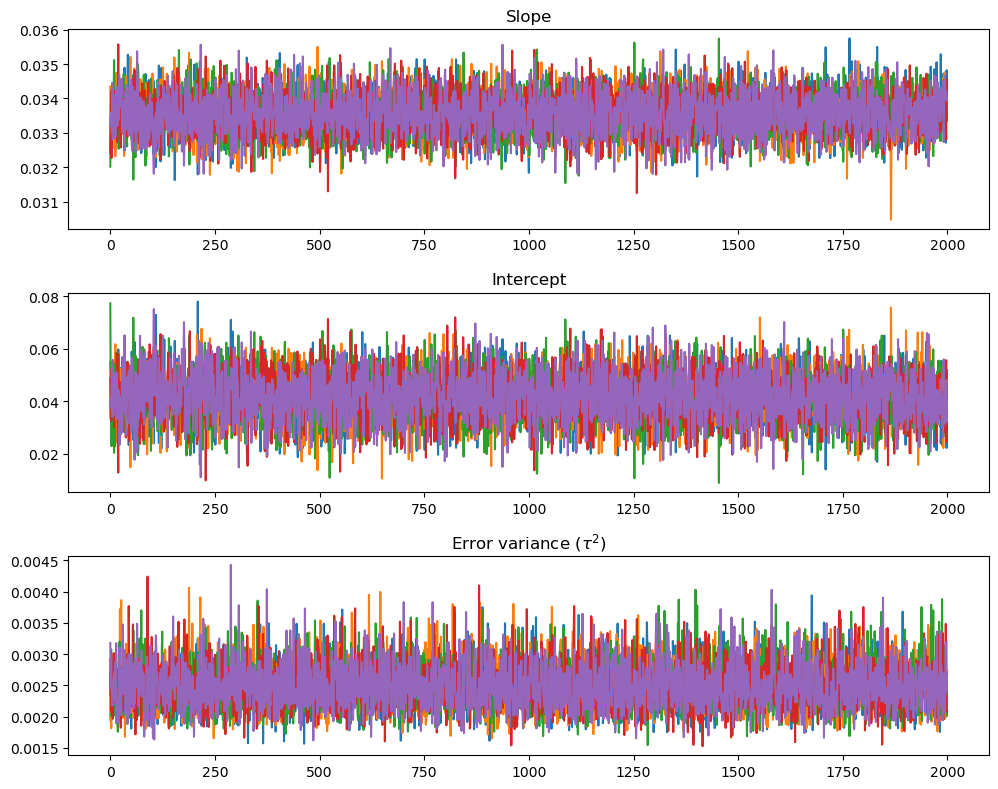

In [72]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
axes[0].plot(b_draws[:, :, 0].T)
axes[0].set_title("Slope")
axes[1].plot(b_draws[:, :, 1].T)
axes[1].set_title("Intercept")
axes[2].plot(tau2_draws.T)
axes[2].set_title(r"Error variance ($\tau^2$)")
plt.tight_layout()
plt.show()

Each color in each plot reflects the Gibbs sampler at one of the 2000 iterations.  We can see that the sampler generally oscillated around a value for much of the length of the sampler chain.  There is no visible sign that the sampler estimates were drifting by the end of each chain, giving us confidence that we converged on a robust posterior for the parameters by the end of each chain.

We can now discard first 200 samples as burn-in and use th remaining 1800 values for the posterior distribution. We have one more check to do as well, the $\hat{R}$ statistic.

In [84]:
b_draws = b_draws[:, 200:, :]
tau2_draws = tau2_draws[:, 200:]

### Step 7: $\hat{R}$ statistic for convergence

In addition to observing the chains for convergence as we did above, we can calculate the [Gelman-Rubin convergence diagnostic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) ($\hat{R}$).  If our sampler successfully converged, $\hat{R}$ should be very close to one. 

In [87]:
m, n = b_draws.shape[:2] #  number of chains and the number of draws left after burn-in was removed
Bs_var = n / (m - 1) * np.sum((np.mean(b_draws[:, :, 0], axis=1) - np.mean(b_draws[:, :, 0])) ** 2) # between chain variance
Ws_var = np.mean(np.var(b_draws[:, :, 0], axis=1)) # within-chain variance
Rhat = np.sqrt(((n - 1) / n * Ws_var + Bs_var / n) / Ws_var) # Gelman-Rubin convergence diagnostic/Rhat statistic
print("Rhat:", Rhat) # should be very close to 1

Rhat: 0.9999182311863063


That looks pretty good!  Time to look at the posterior distributions on the parameters themselves.

### Step 8: Plot posterior vs prior

We can now compare the prior and posterior distributions.  Ideally we would see that the posterior reflects a narrower distribution that results from the likelihood and the use of the actual X and Y values.  

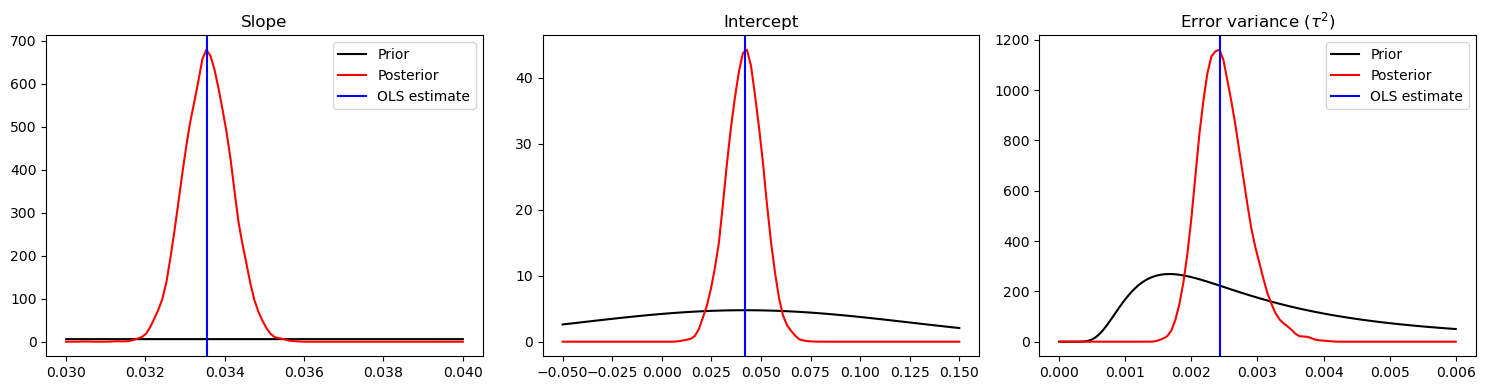

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

xt = np.linspace(0.03, 0.04, 100)

slope_post = gaussian_kde(b_draws[:, :, 0].ravel()).evaluate(xt)
slope_prior = norm.pdf(xt, mean_prior[0], np.sqrt(cov_prior[0, 0]))
axes[0].plot(xt, slope_prior, 'k', label='Prior')
axes[0].plot(xt, slope_post, 'r', label='Posterior')
axes[0].axvline(Bhat[0],0,1, color='b', label='OLS estimate')
axes[0].set_title("Slope")
axes[0].legend()

xt = np.linspace(-0.05, 0.15, 100)
intercept_post = gaussian_kde(b_draws[:, :, 1].ravel()).evaluate(xt)
intercept_prior = norm.pdf(xt, mean_prior[1], np.sqrt(cov_prior[1, 1]))
axes[1].plot(xt, intercept_prior, 'k', label='Prior')
axes[1].plot(xt, intercept_post, 'r', label='Posterior')
axes[1].axvline(Bhat[1],0,1, color='b', label='OLS estimate')
axes[1].set_title("Intercept")

xt = np.linspace(0, 0.006, 100)
tau2_post = gaussian_kde(tau2_draws.ravel()).evaluate(xt)
tau2_prior = invgamma.pdf(xt, a, scale=b)
axes[2].plot(xt, tau2_prior, 'k', label='Prior')
axes[2].plot(xt, tau2_post, 'r', label='Posterior')
axes[2].axvline(tau2hat,0,1, color='b', label='OLS estimate')
axes[2].set_title(r"Error variance ($\tau^2$)")
axes[2].legend()
plt.tight_layout()
plt.show()

We can see that in all cases the posterior distribution is narrower that the prior (and in the case of the slope prior, much narrower!).  This is a good indication that we successfully updated our prior expectations based on the observations.  

At this point, we can feel confident that we have a good solution and we can save our posterior distributions.  We'll use `pickle` here, which is Python's way of 'serializing' objects, but for our purposes we're just saving data in a Python-convenient way.  

Our saved posteriors will 'collapse' the 5 chains and subsample them (every-other-value from a chain) - this gives us the benefit of the 5 chain estimates (less the burn in) and also deals with the autocorrelation.  We'll later use this posterior distribution. 

In [94]:
import pickle

b_draws_final = b_draws[:, ::2, :].reshape(-1, X.shape[1])  # Thin out the samples in each chain to reduce autocorrelation and combine chains
tau2_draws_final = tau2_draws[:, ::2].ravel() # Thin out the samples in each chain to reduce autocorrelation and combine chains

# write thinned out samples to pickle file
with open('regression_demo_results.pkl', 'wb') as f: # weirdly, pickle requires an object, not just a filename
    pickle.dump({'b_draws_final': b_draws_final, 'tau2_draws_final': tau2_draws_final}, f)

We can visualize our posterior Bayesian solution to the linear regression problem:

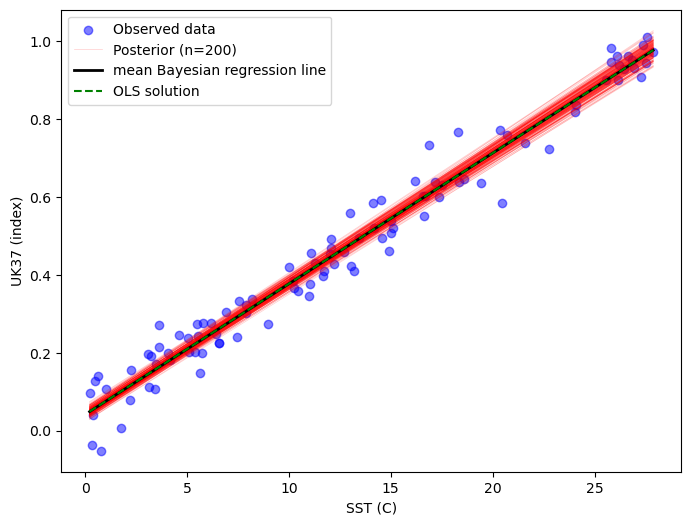

In [97]:
# scatter plot of the original data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], Y, color='blue', alpha=0.5, label='Observed data')

# use raw posterior samples for slope and intercept
n_samples = 200  # Number of posterior samples to use for plotting 
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

# plot regression lines from posterior samples
for i in range(n_samples):
    slope_sample = np.random.choice(b_draws_final[:, 0])  # draw randomly from the slope draws
    intercept_sample = np.random.choice(b_draws_final[:, 1])  # draw randomly from the intercept draws
    y_vals = slope_sample * x_vals + intercept_sample # calculate the line for that set of posterior coefficients
    if i == 0:
        plt.plot(x_vals, y_vals, color='red', alpha=0.2, linewidth=0.5, label='Posterior (n=200)')
    else:
        plt.plot(x_vals, y_vals, color='red', alpha=0.2, linewidth=0.5)
        
# mean regression line using the mean of all the posterior coefficients
mean_slope = np.mean(b_draws_final[:, 0])
mean_intercept = np.mean(b_draws_final[:, 1])
mean_y_vals = mean_slope * x_vals + mean_intercept
plt.plot(x_vals, mean_y_vals, color='black', linewidth=2, label='mean Bayesian regression line')

# OLS regression line
ols_slope = Bhat[0]
ols_intercept = Bhat[1]
ols_y_vals = ols_slope * x_vals + ols_intercept
plt.plot(x_vals, ols_y_vals, color='green', linewidth=1.5, linestyle='--', label='OLS solution')

# Labeling the plot
plt.xlabel('SST (C)')
plt.ylabel('UK37 (index)')
plt.legend()
plt.show()


## From calibration to prediction

One of the strengths of the Bayesian approach is it allows us 'invert' the calibration relationship above if we acquire new UK37 proxy data that we would like to use to estimate past SST!  In many frequentist approaches, this inversion comes with some risks, including regression dilution.  But the Bayesian approach allows us to estimate SST from UK37 using the posterior distributions of the parameters.  

Let's see how this works.  Let's first simulate some 'new' UK37 proxy data from a sediment core -- remember we don't know the SST values for these (they might be from thousands or millions of years ago), but we want to estimate past SSTs from these organic geochemical proxies.

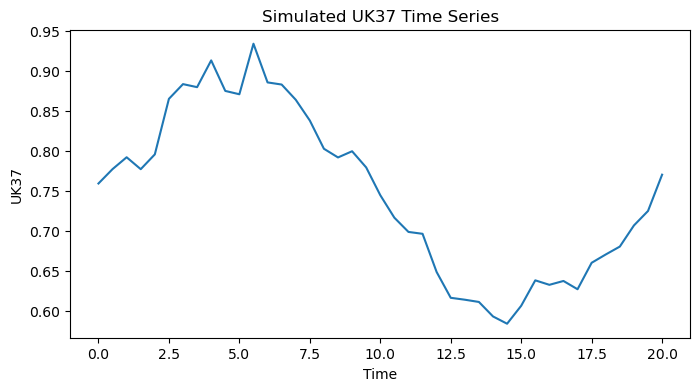

In [100]:
# Generate a synthetic UK37 time series
t = np.arange(0, 20.5, 0.5) # time steps - in thousands of years - so essentially 'last glacial' to present
f = 1 / 20 # we'll give our times series a curve
s_curve = np.sin(2 * np.pi * f * t)
UK_sim = ((s_curve - np.mean(s_curve)) / np.std(s_curve) + np.random.normal(0.5, 0.2, len(t))) * 0.1 + 0.7

# Visualize the synthetic UK37 time series
plt.figure(figsize=(8, 4))
plt.plot(t, UK_sim )
plt.xlabel("Time")
plt.ylabel("UK37")
plt.title("Simulated UK37 Time Series")
plt.show()


We now go through the predictions procedure.  This involves several steps:

1. we provide the mean and standard deviation for a prior distribution in SST.  This should be broad but can be informed by e.g. where we are in the world.  We also need the prior inverse variance (since we are going UK37 to SST) - this is simply the reciprocal of the prior standard deviation squared. 
2. We'll preallocate to receive the SST posterior based on the number of observations of UK37 and the total size of the posterion (4500 in our case)
3. We then enter a loop, where several things happen:
   - we draw out the ith posterior parameter values
   - We calculate posterior covariance.  This is 1 divided by the sum of the prior inverse variance and the squared slope, divide by the posterior variance.  The prior inverse variance reflects how well we think we know the SST value and the influence of how well we know UK37 for informing us about SST.  Here a large value would mean that the UK37 value provides strong evidence for the corresponding SST.  Or, put another way the posterior precision is the sum of the prior precision and the data derived precision - Bayes Rule again! 
   - We calculate the 'posterior mean factor', which combines: (1) our prior on SST with the observed relationship between SST and UK37, and (2) the observational information that informs the posterior mean.  The term $\frac{\beta_{\text{now}}}{\tau_{\text{now}}}$ specifically reflects the strength of the relationship (the slope, $\beta$) and the precision of the observations.  $(\text{UK\_sim} - \alpha_{\text{now}})$ removes the influence of the intercept so we can use the direct relationship between SST and UK37.
   - The full posterior mean is then the posterior covariance and the posterior mean factor

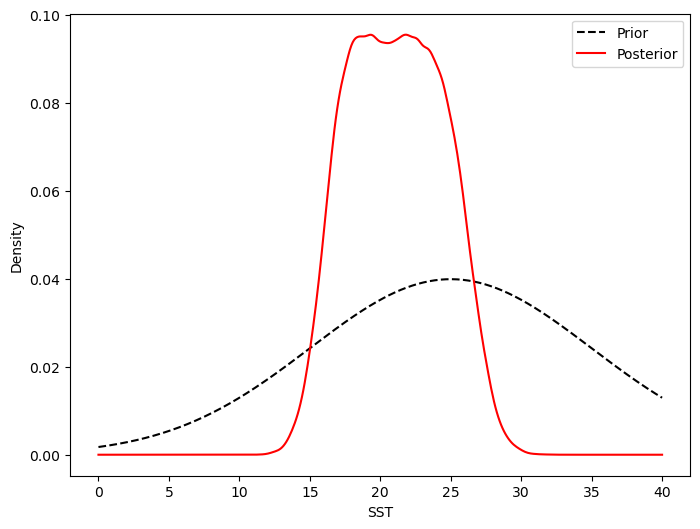

In [104]:
# Define a quite wide prior for SST
prior_mean = 25
prior_std = 10
prior_inv_var = 1 / prior_std**2

# Set up loop to predict SST for each simulated UK37 value
N_Ts = len(UK_sim)
SST = np.empty((N_Ts, len(tau2_draws_final))) # pre-allocate an array to accept the SST predictions

# loop over 4500 posterior values (5 chains, 900 retained values from each) for each parameter
for i in range(len(tau2_draws_final)):
    beta_now = b_draws_final[i, 0] # draw out a beta 
    alpha_now = b_draws_final[i, 1] # draw out an intercept
    tau_now = tau2_draws_final[i] # draw out a residual variable
    
    # 1st term: posterior covariance
    post_cov = 1 / (prior_inv_var + (beta_now**2) / tau_now) # inverse prior times the residual variable scaled by the square of the slope - gives a combined measure of confidence in SST given observed UK37 
    
    # 2nd term: 'posterior mean factor' (41,) - note the dimension here and in the next line comes from the data here (41 time points)
    mean_first = prior_inv_var * prior_mean + (beta_now / tau_now) * (UK_sim - alpha_now) # combines prior expectation of SST (the prior mean) with the evidence for the SST/UK37 relationship, weighted by the precision of the posterior distribution
    
    # full posterior mean (41,) - uncertainties in the parameters and combined with prior expectation and with evidence from the observed response weighted by precision
    Mean_full = post_cov * mean_first # the product of the posterior covariance (precision from prior and data) and the mean factor (combination of the prior and observed UK37)
    
    # now, draw from the posterior distribution for the SST values associated with the posterior parameters and the data
    SST[:, i] = np.random.normal(Mean_full, np.sqrt(post_cov)) # potential SST is a draw from a random normal with mean from the full mean and the posterior standard deviation

# Visualization of Prior vs Posterior for SST
xt = np.linspace(0, 40, 400)
prior_dist = norm.pdf(xt, prior_mean, prior_std)
posterior_density = gaussian_kde(SST.flatten())  # Kernel density estimation for posterior
post_dist = posterior_density(xt)

plt.figure(figsize=(8, 6))
plt.plot(xt, prior_dist, 'k--', label='Prior')
plt.plot(xt, post_dist, 'r', label='Posterior')
plt.xlabel("SST")
plt.ylabel("Density")
plt.legend()
plt.show()


We can see that our posterior SST distribution is quite a bit tighter than the wide prior we used! 

We can now plot these posterior estimates of the SST in time along with their uncertainty.  We first sort the posterior SST (41 UK37 measurements, 4500 posterior estimates of SST) so we can get an empirical upper and lower bound for the SST prediction. 

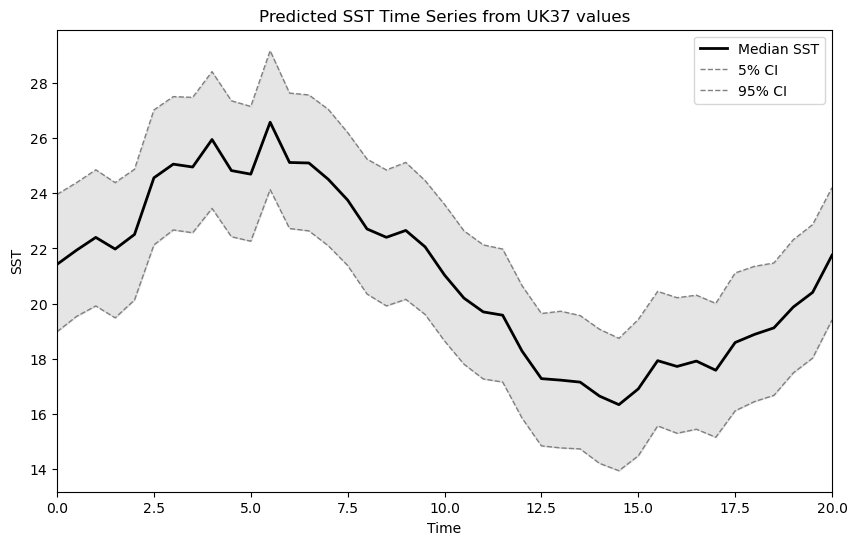

In [106]:
# Plot SST Time Series with 90% Confidence Interval
SST_sorted = np.sort(SST, axis=1) # SST is 41 by 4500 for this example
lower_bound = SST_sorted[:, int(0.05 * len(tau2_draws_final))] # gets 5%
median = SST_sorted[:, int(0.5 * len(tau2_draws_final))] # gets median
upper_bound = SST_sorted[:, int(0.95 * len(tau2_draws_final))] # gets 95%

plt.figure(figsize=(10, 6))
plt.plot(t, median, color='k', linewidth=2, label="Median SST")
plt.plot(t, lower_bound, color='gray', linestyle='--', linewidth=1, label="5% CI")
plt.plot(t, upper_bound, color='gray', linestyle='--', linewidth=1, label="95% CI")
plt.fill_between(t, lower_bound, upper_bound, color='gray', alpha=0.2)
plt.xlim(min(t), max(t))
plt.xlabel("Time")
plt.ylabel("SST")
plt.title("Predicted SST Time Series from UK37 values")
plt.legend()
plt.show()